# SET UP

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import time
import os
import pandas as pd
import shutil
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# library used to process audio 
import librosa
from librosa import display
import IPython.display as ipd

plt.figure(figsize=(14,5))
DATAPATH = './archive'
dir_list = os.listdir(DATAPATH)
print(dir_list)
#print(os.listdir(os.path.join(DATAPATH,dir_list[0])))

from vscode_audio import Audio
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


<Figure size 1008x360 with 0 Axes>

In [4]:
from tensorflow.python.client import device_lib
tf.config.experimental.list_physical_devices('GPU')
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12302964843140376445
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6963920896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3190741005991853899
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
Num GPUs Available:  1


# takes a look at the audio and visualize it

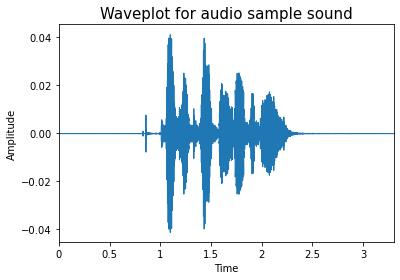

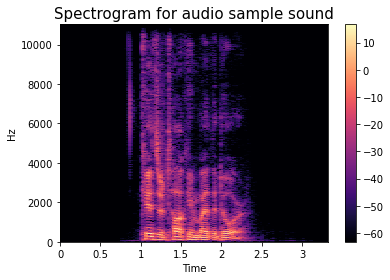

In [5]:
testpath = os.path.join(DATAPATH, "Actor_01/03-01-01-01-01-01-01.wav")
def generate_sound(path):
    ipd.Audio(path)
def generate_waveplot(path, title):
    plt.title('Waveplot for audio {}'.format(title), size=15)
    x,fs = librosa.load(testpath)
    librosa.display.waveplot(x, sr=fs)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

def generate_spectrogram(path, title):
    x,fs = librosa.load(testpath)
    x = librosa.stft(x)
    x = librosa.amplitude_to_db(abs(x))
    plt.title('Spectrogram for audio {}'.format(title), size=15)
    librosa.display.specshow(x, sr=fs, x_axis='time', y_axis='hz')   
    plt.colorbar()
generate_sound(testpath)
generate_waveplot(testpath, "sample sound")
generate_spectrogram(testpath,"sample sound")

In [6]:
data, rate = librosa.load(testpath)

# Emotion Representation
https://www.youtube.com/watch?v=26_qiXEa8lw
* three Dimensional
 * Valence (negative - positive)
 * Activation (low - high)
 * Dominance (Dominated - dominant)
* Two Dimensional
 * arousal
 * valence

* features
 * zero-crossing rate
 * chroma_stft
 * chroma_cqt
 * chroma_cens
 * mel-frequency cepstral coefficient
 * root mean square value
 * melspectogram

# Zero-Crossing Rate
https://academic.microsoft.com/topic/2776860830/publication/search?q=Zero-crossing%20rate&qe=And(Composite(F.FId%253D2776860830)%252CTy%253D%270%27)&f=&orderBy=0 <br/>

is the rate at which a signal changes from positive to negative or from negative to positive. is a key feature to classify percussive sounds

In [20]:
test_zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
len(test_zcr)

1

In [21]:
stft = np.abs(librosa.stft(data))
test_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
len(test_stft)

12

# Mel-Frequency Cepstral Coefficient
https://www.youtube.com/watch?v=4_SH2nfbQZ8 <br />
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
* cepstral 
$C(x(t)) = F^{-1}[log(F[x(t)])]$
* MFCCs advantages
 * Describe the "large" structures of the spectrum
 * ignore fine spectral structures, really don't care on the pitch, etc.
 * work wll in speech and music processing
* MFCCs are commonly used as features in speech recognition systems, such as the systems which can automatically recognize numbers spoken into a telephone

In [22]:
test_mfcc = np.mean(librosa.feature.mfcc(y=data, sr=rate).T, axis=0)
len(test_mfcc)

20

In [23]:
test_rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
len(test_rms)

1

In [24]:
test_mels = np.mean(librosa.feature.melspectrogram(y=data, sr=rate).T, axis=0)
len(test_mels)

128

# Data Augmentation

* noise
* time shifting
* time stretching
* pitch shifting

Data augmentation is a method for generating synthetic data

Sound wave has following characteristics: Pitch, Loudness, Quality. We need to alter our samples around these characteristics in such a way that they only differ by small factor from original sample.


In [7]:
def noise(wav, p):
    return wav + p*np.random.normal(0,1,len(wav))
def time_shifting(wav,p):
    return np.roll(wav,p)
def time_stretching(wav,p):
    return librosa.effects.time_stretch(wav,p)
def pitch_shifting(wav,sr, p):
    return librosa.effects.pitch_shift(wav,sr,n_steps=p)


In [18]:

ipd.Audio(data, rate=rate)

In [9]:
ipd.Audio(noise(data,0.004),rate=rate)

In [45]:
ipd.Audio(time_shifting(data,int(rate*100)),rate=rate)

In [11]:
ipd.Audio(time_stretching(data,0.5),rate=rate)

In [12]:
ipd.Audio(pitch_shifting(data,rate,-5),rate=rate)

# Extract data


using MFCC to summary the frequency distribution, and use to identify features for classification

In [8]:
mfccs = librosa.feature.mfcc(y=data,sr=rate,n_mfcc=40)
print(mfccs.shape)

(40, 143)


In [9]:
def files_info_extractor(path):
    dir_list = os.listdir(path)
    y = []
    X = []
    for i in range(len(dir_list)):
        files = os.listdir(os.path.join(path,dir_list[i]))
        for j in range(len(files)):
            X.append([files[j],
                      int(files[j][0:2]),
                     int(files[j][3:5]),
                     int(files[j][6:8]),
                     int(files[j][9:11]),
                    int(files[j][12:14]),
                    int(files[j][15:17]),
                    int(files[j][18:20])])
    return X
info = files_info_extractor(DATAPATH)
info_df = pd.DataFrame(info, columns =["Url", 
                               'Modality', 
                               'Vocal channel',
                              'Emotion',
                              'Emotional intensity',
                              'Statement',
                              'Repetition',
                              'Actor'])


In [10]:
info_df

,Url,Modality,Vocal channel,Emotion,Emotional intensity,Statement,Repetition,Actor
0,03-01-01-01-01-01-01.wav,3,1,1,1,1,1,1
1,03-01-01-01-01-02-01.wav,3,1,1,1,1,2,1
2,03-01-01-01-02-01-01.wav,3,1,1,1,2,1,1
3,03-01-01-01-02-02-01.wav,3,1,1,1,2,2,1
4,03-01-02-01-01-01-01.wav,3,1,2,1,1,1,1
...,...,...,...,...,...,...,...,...
1435,03-01-08-01-02-02-24.wav,3,1,8,1,2,2,24
1436,03-01-08-02-01-01-24.wav,3,1,8,2,1,1,24
1437,03-01-08-02-01-02-24.wav,3,1,8,2,1,2,24
1438,03-01-08-02-02-01-24.wav,3,1,8,2,2,1,24


C:\Users\15197\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


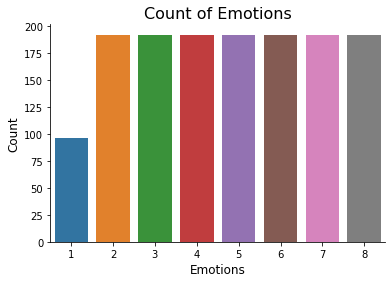

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(info_df["Emotion"])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
def transfer_all_audios():
    actors = os.listdir(DATAPATH)
    for actor in actors:
        audios = os.listdir(os.path.join(DATAPATH,actor))
        for audio in audios:
            shutil.copy2(os.path.join(DATAPATH,actor,audio), os.path.join("audios",audio))
os.system("mkdir audios")
os.system("rm -r audios/*")
transfer_all_audios()

<h2> create function to exctract the features of an audio </h2>

In [12]:
def generate_zcr(data,rate):
    return np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
def generate_stft(data,rate):
    stft = np.abs(librosa.stft(data))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
def generate_mfcc(data,rate):
    return np.mean(librosa.feature.mfcc(y=data, sr=rate).T, axis=0)

def generate_rms(data, rate):
    return np.mean(librosa.feature.rms(y=data).T, axis=0)
def generate_mels(data, rate):
    return np.mean(librosa.feature.melspectrogram(y=data, sr=rate).T, axis=0)
def generate_cqt(data, rate):
    return np.mean(librosa.feature.chroma_cqt(y=data,sr=rate).T,axis=0)
def generate_cens(data, rate):
    return np.mean(librosa.feature.chroma_cens(y=data,sr=rate).T, axis=0)

In [13]:
def featuresGenerator(data,rate,paras):
    features = np.array([])
    for para in paras:
        if (para == "zcr"):
            features = np.hstack((features,generate_zcr(data, rate)))
        elif (para=="stft"):
            features = np.hstack((features,generate_stft(data, rate)))
        elif (para=="mfcc"):
            features = np.hstack((features,generate_mfcc(data, rate)))
        elif (para == "rms"):
            featurse = np.hstack((features,generate_rms(data, rate)))
        elif (para == "mels"):
            features = np.hstack((features,generate_mels(data, rate)))
        elif (para == "cqt"):
            features = np.hstack((features,generate_cqt(data, rate)))
        elif (para == "cens"):
            features = np.hstack((features.generate_cens(data,rate)))
        else:
            print("wrong features")
    return features


def extract_feature(path,paras, augs):
    data, rate = librosa.load(path)
    if (len(augs)==0):
        return np.array([featuresGenerator(data,rate,paras)])
    result = np.array(featuresGenerator(data,rate,paras))
    for aug in augs:
        if (aug == "noise"):
            result = np.vstack((result,featuresGenerator(noise(data,0.004),rate,paras)))
        elif (aug == "time_shift"):
            result = np.vstack((result, featuresGenerator(time_shifting(data,int(rate/10)),rate,paras)))
        elif (aug == "time_stretch"):
            result = np.vstack((result, featuresGenerator(time_stretching(data,0.5),rate,paras)))
        elif (aug == "pitch_shift"):
            result = np.vstack((result, featuresGenerator(pitch_shifting(data,rate,-5),rate,paras)))
        else:
            print("wrong augmentation")
    return result

def get_features(paras,augs):
    X = []
    y = [] 
    for i in range(len(info_df)):
        path = os.path.join("audios",info_df["Url"][i])
        features = extract_feature(path,paras,augs)
        for f in features:
            
            X.append(f)
            y.append(info_df["Emotion"][i])

    return X,y


<h2> define the function to build baseline model which used to be compared with other improved model </h2>

In [14]:



def build(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(pd.DataFrame(x_train).shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(8))
    model.add(Activation('softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

# check the simplest model

In [72]:
X,y = get_features(["mfcc"],[])
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
print(pd.DataFrame(X))

              0          1          2          3          4          5   \
0    -697.984192  55.228489   0.323863  12.775377   7.396148   0.866224   
1    -693.069702  55.734570  -1.919739  16.408995   8.449354   0.220736   
2    -691.770142  58.350647  -0.165160  13.952125   5.053323   1.489326   
3    -685.237915  56.236691   2.453112  13.566655   6.701949   3.341493   
4    -727.317932  62.764400   2.751275  15.473256   7.763115   2.330714   
...          ...        ...        ...        ...        ...        ...   
1435 -586.762634  25.372396 -17.824156  -1.315452 -15.738236  -9.392014   
1436 -532.757446  38.194206 -15.409904  -5.477151 -15.620424 -13.425549   
1437 -541.550232  30.086676 -18.491722  -2.648303 -14.771161 -17.068848   
1438 -492.985962  24.425610  -6.565718   2.215220 -11.599139  -4.619690   
1439 -518.293823  30.043261  -4.414401  -0.645565  -5.760980  -6.644137   

             6          7          8         9         10        11        12  \
0     -3.550276  -

In [73]:
print(pd.DataFrame(y))

        0    1    2    3    4    5    6    7
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...
1435  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1436  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1437  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1438  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1439  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

[1440 rows x 8 columns]


Epoch 1/200
9/9 [==============================] - 1s 40ms/step - loss: 18.6786 - accuracy: 0.1308 - val_loss: 5.9784 - val_accuracy: 0.1389
Epoch 2/200
9/9 [==============================] - 0s 10ms/step - loss: 4.7099 - accuracy: 0.1296 - val_loss: 2.3794 - val_accuracy: 0.1042
Epoch 3/200
9/9 [==============================] - 0s 10ms/step - loss: 2.4667 - accuracy: 0.1539 - val_loss: 2.1501 - val_accuracy: 0.1528
Epoch 4/200
9/9 [==============================] - 0s 10ms/step - loss: 2.1134 - accuracy: 0.1794 - val_loss: 2.0220 - val_accuracy: 0.2188
Epoch 5/200
9/9 [==============================] - 0s 10ms/step - loss: 2.0849 - accuracy: 0.1655 - val_loss: 1.9903 - val_accuracy: 0.2153
Epoch 6/200
9/9 [==============================] - 0s 10ms/step - loss: 2.0303 - accuracy: 0.2118 - val_loss: 1.9926 - val_accuracy: 0.1736
Epoch 7/200
9/9 [==============================] - 0s 10ms/step - loss: 1.9940 - accuracy: 0.2060 - val_loss: 2.0158 - val_accuracy: 0.1910
Epoch 8/200
9/9 [==

9/9 [==============================] - 0s 9ms/step - loss: 0.5022 - accuracy: 0.8171 - val_loss: 1.6320 - val_accuracy: 0.5139
Epoch 118/200
9/9 [==============================] - 0s 9ms/step - loss: 0.5151 - accuracy: 0.8171 - val_loss: 1.5215 - val_accuracy: 0.5139
Epoch 119/200
9/9 [==============================] - 0s 9ms/step - loss: 0.5185 - accuracy: 0.8252 - val_loss: 1.5767 - val_accuracy: 0.5312
Epoch 120/200
9/9 [==============================] - 0s 9ms/step - loss: 0.5255 - accuracy: 0.8137 - val_loss: 1.4892 - val_accuracy: 0.5243
Epoch 121/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4946 - accuracy: 0.8345 - val_loss: 1.5604 - val_accuracy: 0.5243
Epoch 122/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4814 - accuracy: 0.8380 - val_loss: 1.5723 - val_accuracy: 0.5243
Epoch 123/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4747 - accuracy: 0.8287 - val_loss: 1.5155 - val_accuracy: 0.5417
Epoch 124/200
9/9 [========

<AxesSubplot:>

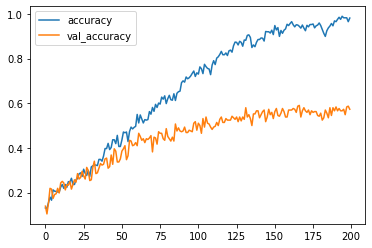

In [74]:
x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
model = build(x_train)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
        
history=model.fit(x_train, y_train, batch_size=100, epochs=200, validation_data=(x_val, y_val))
loss_history = pd.DataFrame(history.history)
loss_history[['accuracy','val_accuracy']].plot()

<h2> define function to compare accuracy between different features selection </h2>

In [15]:
def compared_paras():
    paras = ["stft","mfcc","mels","cqt","cens"]
    historys = []
    for para in paras:
        X,y = get_features([para],[])
        encoder = OneHotEncoder()
        y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
        x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
        x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
        model = build(x_train)
        #scaler = StandardScaler()
        #x_train = scaler.fit_transform(x_train)
        #x_test = scaler.transform(x_test)
        #x_val = scaler.transform(x_val)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        x_val = np.expand_dims(x_val, axis=2)
        
        history=model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=para)
    plt.legend()
    plt.savefig("compared_paras_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.show()
    return historys

In [ ]:
paras_historys = compared_paras()

Epoch 1/50
54/54 [==============================] - 8s 8ms/step - loss: 2.0706 - accuracy: 0.1238 - val_loss: 2.0768 - val_accuracy: 0.1215
Epoch 2/50
54/54 [==============================] - 0s 5ms/step - loss: 2.0642 - accuracy: 0.1447 - val_loss: 2.0695 - val_accuracy: 0.1354
Epoch 3/50
54/54 [==============================] - 0s 5ms/step - loss: 2.0617 - accuracy: 0.1389 - val_loss: 2.0763 - val_accuracy: 0.1354
Epoch 4/50
54/54 [==============================] - 0s 5ms/step - loss: 2.0635 - accuracy: 0.1528 - val_loss: 2.0724 - val_accuracy: 0.0972
Epoch 5/50
54/54 [==============================] - 0s 5ms/step - loss: 2.0616 - accuracy: 0.1400 - val_loss: 2.0705 - val_accuracy: 0.1354
Epoch 6/50
54/54 [==============================] - 0s 5ms/step - loss: 2.0610 - accuracy: 0.1505 - val_loss: 2.0700 - val_accuracy: 0.1354
Epoch 7/50
54/54 [==============================] - 0s 5ms/step - loss: 2.0610 - accuracy: 0.1458 - val_loss: 2.0713 - val_accuracy: 0.1354
Epoch 8/50
54/54 [==

54/54 [==============================] - 0s 5ms/step - loss: 1.8759 - accuracy: 0.2697 - val_loss: 1.9061 - val_accuracy: 0.2083
Epoch 10/50
54/54 [==============================] - 0s 5ms/step - loss: 1.8833 - accuracy: 0.2546 - val_loss: 1.8692 - val_accuracy: 0.2361
Epoch 11/50
54/54 [==============================] - 0s 5ms/step - loss: 1.8791 - accuracy: 0.2523 - val_loss: 1.8487 - val_accuracy: 0.2778
Epoch 12/50
54/54 [==============================] - 0s 5ms/step - loss: 1.8545 - accuracy: 0.2593 - val_loss: 1.8506 - val_accuracy: 0.2986
Epoch 13/50
54/54 [==============================] - 0s 5ms/step - loss: 1.8603 - accuracy: 0.2708 - val_loss: 1.9816 - val_accuracy: 0.2118
Epoch 14/50
54/54 [==============================] - 0s 5ms/step - loss: 1.8449 - accuracy: 0.2801 - val_loss: 1.8388 - val_accuracy: 0.2674
Epoch 15/50
54/54 [==============================] - 0s 5ms/step - loss: 1.8071 - accuracy: 0.2558 - val_loss: 1.7785 - val_accuracy: 0.2882
Epoch 16/50
54/54 [======

54/54 [==============================] - 0s 6ms/step - loss: 1.6930 - accuracy: 0.3472 - val_loss: 2.0248 - val_accuracy: 0.2743
Epoch 18/50
54/54 [==============================] - 0s 6ms/step - loss: 1.6935 - accuracy: 0.3495 - val_loss: 1.7634 - val_accuracy: 0.3021
Epoch 19/50
54/54 [==============================] - 0s 6ms/step - loss: 1.6649 - accuracy: 0.3391 - val_loss: 1.7621 - val_accuracy: 0.3194
Epoch 20/50
54/54 [==============================] - 0s 6ms/step - loss: 1.6718 - accuracy: 0.3461 - val_loss: 1.7561 - val_accuracy: 0.3160
Epoch 21/50
54/54 [==============================] - 0s 6ms/step - loss: 1.6393 - accuracy: 0.3750 - val_loss: 1.8079 - val_accuracy: 0.2882
Epoch 22/50
54/54 [==============================] - 0s 6ms/step - loss: 1.6259 - accuracy: 0.3646 - val_loss: 1.7268 - val_accuracy: 0.3333
Epoch 23/50
54/54 [==============================] - 0s 6ms/step - loss: 1.6555 - accuracy: 0.3576 - val_loss: 1.8142 - val_accuracy: 0.3090
Epoch 24/50
54/54 [======

In [34]:
def compared_multiple_paras():
    paras = ["mels","stft","mfcc","rms","zcr"]
    historys = []
    for i in range(len(paras)):
        para = paras[i]
        X,y = get_features(paras[:i+1],[])
        encoder = OneHotEncoder()
        y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
        x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
        x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
        model = build(x_train)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        x_val = np.expand_dims(x_val, axis=2)
        
        history=model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val))
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=paras[:i+1])
    plt.legend()
    plt.savefig("compared_multiple_paras_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.show()
    return historys

Epoch 1/30
14/14 [==============================] - 1s 31ms/step - loss: 2.0782 - accuracy: 0.1238 - val_loss: 2.0758 - val_accuracy: 0.1354
Epoch 2/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0718 - accuracy: 0.1285 - val_loss: 2.0735 - val_accuracy: 0.1354
Epoch 3/30
14/14 [==============================] - 0s 12ms/step - loss: 2.0675 - accuracy: 0.1192 - val_loss: 2.0689 - val_accuracy: 0.1389
Epoch 4/30
14/14 [==============================] - 0s 12ms/step - loss: 2.0681 - accuracy: 0.1331 - val_loss: 2.0720 - val_accuracy: 0.1389
Epoch 5/30
14/14 [==============================] - 0s 12ms/step - loss: 2.0656 - accuracy: 0.1574 - val_loss: 2.0706 - val_accuracy: 0.1354
Epoch 6/30
14/14 [==============================] - 0s 12ms/step - loss: 2.0647 - accuracy: 0.1169 - val_loss: 2.0699 - val_accuracy: 0.1354
Epoch 7/30
14/14 [==============================] - 0s 12ms/step - loss: 2.0610 - accuracy: 0.1551 - val_loss: 2.0702 - val_accuracy: 0.1354
Epoch 8/30
14

Epoch 29/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0563 - accuracy: 0.1574 - val_loss: 2.0724 - val_accuracy: 0.1354
Epoch 30/30
14/14 [==============================] - 0s 12ms/step - loss: 2.0596 - accuracy: 0.1377 - val_loss: 2.0719 - val_accuracy: 0.1354
Epoch 1/30
14/14 [==============================] - 1s 32ms/step - loss: 4.8010 - accuracy: 0.1169 - val_loss: 2.0788 - val_accuracy: 0.1597
Epoch 2/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0788 - accuracy: 0.1262 - val_loss: 2.0781 - val_accuracy: 0.1493
Epoch 3/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0779 - accuracy: 0.1343 - val_loss: 2.0774 - val_accuracy: 0.1354
Epoch 4/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0783 - accuracy: 0.1458 - val_loss: 2.0769 - val_accuracy: 0.1354
Epoch 5/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0761 - accuracy: 0.1458 - val_loss: 2.0764 - val_accuracy: 0.1354
Epoch 6/30


Epoch 27/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0633 - accuracy: 0.1458 - val_loss: 2.0721 - val_accuracy: 0.1354
Epoch 28/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0629 - accuracy: 0.1458 - val_loss: 2.0721 - val_accuracy: 0.1354
Epoch 29/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0626 - accuracy: 0.1458 - val_loss: 2.0720 - val_accuracy: 0.1354
Epoch 30/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0623 - accuracy: 0.1458 - val_loss: 2.0719 - val_accuracy: 0.1354
Epoch 1/30
14/14 [==============================] - 1s 42ms/step - loss: 9.7840 - accuracy: 0.1516 - val_loss: 2.0785 - val_accuracy: 0.1354
Epoch 2/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0796 - accuracy: 0.1458 - val_loss: 2.0780 - val_accuracy: 0.1354
Epoch 3/30
14/14 [==============================] - 0s 13ms/step - loss: 2.0774 - accuracy: 0.1458 - val_loss: 2.0776 - val_accuracy: 0.1354
Epoch 4/3

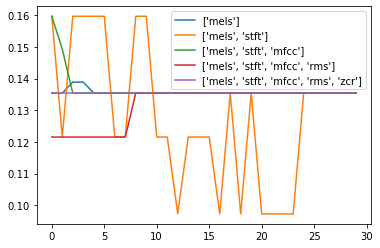

In [35]:
compared_multiple_paras()

<h2> compare the accuracy between different data augmentation </h2>

In [37]:
def compared_augs():
    paras = ["noise","time_shift","time_stretch","pitch_shift"]
    historys = []
    for i in range(len(paras)):
        para = paras[i]
        X,y = get_features(["mels","mfcc"],paras[:i+1])
        encoder = OneHotEncoder()
        y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
        x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
        x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
        model = build(x_train)
        x_train = np.expand_dims(x_train, axis=2)
        x_test = np.expand_dims(x_test, axis=2)
        x_val = np.expand_dims(x_val, axis=2)
        
        history=model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val))
        historys.append(history)
        loss_history = pd.DataFrame(history.history)
        plt.plot(loss_history['val_accuracy'],label=paras[:i+1])
    plt.legend()
    plt.savefig("compared_multiple_augs_"+time.strftime("%Y%m%d-%H%M%S")+".png")
    plt.show()
    return historys

In [39]:
X,y = get_features(["mfcc","mels"],["noise","time_shift"])


In [40]:
info = pd.DataFrame(X)
info.shape

(4320, 148)

Epoch 1/30
27/27 [==============================] - 1s 17ms/step - loss: 4.3259 - accuracy: 0.1209 - val_loss: 2.0789 - val_accuracy: 0.1250
Epoch 2/30
27/27 [==============================] - 0s 12ms/step - loss: 2.0783 - accuracy: 0.1360 - val_loss: 2.0777 - val_accuracy: 0.1250
Epoch 3/30
27/27 [==============================] - 0s 12ms/step - loss: 2.0771 - accuracy: 0.1343 - val_loss: 2.0766 - val_accuracy: 0.1319
Epoch 4/30
27/27 [==============================] - 0s 12ms/step - loss: 2.0759 - accuracy: 0.1296 - val_loss: 2.0753 - val_accuracy: 0.1250
Epoch 5/30
27/27 [==============================] - 0s 12ms/step - loss: 2.0747 - accuracy: 0.1406 - val_loss: 2.0741 - val_accuracy: 0.1319
Epoch 6/30
27/27 [==============================] - 0s 12ms/step - loss: 2.0787 - accuracy: 0.1418 - val_loss: 2.0730 - val_accuracy: 0.1319
Epoch 7/30
27/27 [==============================] - 0s 12ms/step - loss: 2.0725 - accuracy: 0.1424 - val_loss: 2.0719 - val_accuracy: 0.1319
Epoch 8/30
27

Epoch 26/30
68/68 [==============================] - 1s 11ms/step - loss: 2.0623 - accuracy: 0.1296 - val_loss: 2.0604 - val_accuracy: 0.1292
Epoch 27/30
68/68 [==============================] - 1s 11ms/step - loss: 2.0622 - accuracy: 0.1368 - val_loss: 2.0602 - val_accuracy: 0.1292
Epoch 28/30
68/68 [==============================] - 1s 11ms/step - loss: 2.0622 - accuracy: 0.1368 - val_loss: 2.0603 - val_accuracy: 0.1292
Epoch 29/30
68/68 [==============================] - 1s 11ms/step - loss: 2.0622 - accuracy: 0.1368 - val_loss: 2.0602 - val_accuracy: 0.1292
Epoch 30/30
68/68 [==============================] - 1s 11ms/step - loss: 2.0622 - accuracy: 0.1368 - val_loss: 2.0602 - val_accuracy: 0.1292


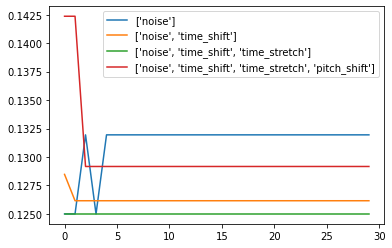

In [38]:
compared_augs()

# final model and evaluate

Epoch 1/200
44/44 [==============================] - 12s 25ms/step - loss: 4.2482 - accuracy: 0.1729 - val_loss: 1.9210 - val_accuracy: 0.2111
Epoch 2/200
44/44 [==============================] - 1s 15ms/step - loss: 1.9136 - accuracy: 0.2259 - val_loss: 1.8187 - val_accuracy: 0.3007
Epoch 3/200
44/44 [==============================] - 1s 15ms/step - loss: 1.8513 - accuracy: 0.2560 - val_loss: 1.7994 - val_accuracy: 0.2681
Epoch 4/200
44/44 [==============================] - 1s 15ms/step - loss: 1.8022 - accuracy: 0.2773 - val_loss: 1.7548 - val_accuracy: 0.3063
Epoch 5/200
44/44 [==============================] - 1s 15ms/step - loss: 1.7738 - accuracy: 0.2873 - val_loss: 1.7096 - val_accuracy: 0.3549
Epoch 6/200
44/44 [==============================] - 1s 15ms/step - loss: 1.7379 - accuracy: 0.3106 - val_loss: 1.6764 - val_accuracy: 0.3653
Epoch 7/200
44/44 [==============================] - 1s 15ms/step - loss: 1.7160 - accuracy: 0.3234 - val_loss: 1.6610 - val_accuracy: 0.3521
Epoch

44/44 [==============================] - 1s 15ms/step - loss: 0.1980 - accuracy: 0.9292 - val_loss: 0.9065 - val_accuracy: 0.7632
Epoch 116/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1829 - accuracy: 0.9345 - val_loss: 0.9701 - val_accuracy: 0.7701
Epoch 117/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1953 - accuracy: 0.9317 - val_loss: 0.9120 - val_accuracy: 0.7701
Epoch 118/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1875 - accuracy: 0.9363 - val_loss: 0.9479 - val_accuracy: 0.7757
Epoch 119/200
44/44 [==============================] - 1s 15ms/step - loss: 0.2065 - accuracy: 0.9241 - val_loss: 0.9474 - val_accuracy: 0.7604
Epoch 120/200
44/44 [==============================] - 1s 15ms/step - loss: 0.2089 - accuracy: 0.9243 - val_loss: 0.9857 - val_accuracy: 0.7715
Epoch 121/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1660 - accuracy: 0.9410 - val_loss: 0.9878 - val_accuracy: 0.7674
Epoch 

Epoch 172/200
44/44 [==============================] - 1s 15ms/step - loss: 0.0983 - accuracy: 0.9637 - val_loss: 1.1280 - val_accuracy: 0.7785
Epoch 173/200
44/44 [==============================] - 1s 15ms/step - loss: 0.0709 - accuracy: 0.9766 - val_loss: 1.2381 - val_accuracy: 0.7757
Epoch 174/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1053 - accuracy: 0.9593 - val_loss: 1.2517 - val_accuracy: 0.7778
Epoch 175/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1386 - accuracy: 0.9519 - val_loss: 1.2813 - val_accuracy: 0.7563
Epoch 176/200
44/44 [==============================] - 1s 15ms/step - loss: 0.2553 - accuracy: 0.9132 - val_loss: 1.2708 - val_accuracy: 0.7437
Epoch 177/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1931 - accuracy: 0.9312 - val_loss: 1.2218 - val_accuracy: 0.7708
Epoch 178/200
44/44 [==============================] - 1s 15ms/step - loss: 0.1853 - accuracy: 0.9405 - val_loss: 1.2820 - val_accuracy:

<AxesSubplot:>

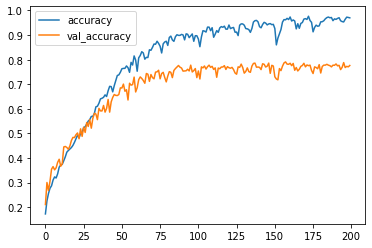

In [26]:
X,y = get_features(["mfcc","stft","mels","zcr","rms"],["noise","time_shift","time_stretch","pitch_shift"])
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
x_train, x_rest, y_train, y_rest = train_test_split(X, y, random_state=0, test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_rest,y_rest,random_state=0,test_size=0.5)
model = build(x_train)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
        
history=model.fit(x_train, y_train, batch_size=100, epochs=500, validation_data=(x_val, y_val))
loss_history = pd.DataFrame(history.history)
loss_history[['accuracy','val_accuracy']].plot()

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0